In [25]:
#!/usr/bin/venv python3.7
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os
import math
import datetime as dt
import numpy as np
import pandas as pd
import sys  
sys.path.insert(0, '/Users/annhuang/code/')
from options.utils.dgp import *
from options.core.instruments import Instrument, implied_forward

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 2000)
import matplotlib.pyplot as plt
%matplotlib inline

## Question 1

For the exercises, I assume the same underlying price distribution and same strike, time to expiry for the stock options, and the stocks pay no dividends, market interest rate is 0%.
Suppose the option contract multiplier is 100 and we buy one lot of 100 call at the end of day 0, the option expiring in exactly a year. Between day 0 and expiry, we hedge only based on the daily closing price to be delta flat (well, we can only hedge with integer amount of stocks). 

If stock prices follow log-normal distribution, then return follows normal distribution. Consider $\ln \frac{P_t}{P_{t-1}} \sim \mathcal{N}(\mu, \sigma^2)$. 
First simulate a return series $\{r_1, r2, \dots, r_n\}$, we have $P_k = P_0 * \exp(\sum_{i}^{k} r_i)$.

In [16]:
TRADING_DAYS = 256
tte = 1
initial_price = 100
strike = 100
annual_return = 0.1
annual_volatility = 0.35
r = 0.00
days_to_expiry = math.floor(tte * TRADING_DAYS)
contract_multiplier = 100

In [17]:
num_stocks = 4
dict_pricing_data = dict()
for i in range(0, num_stocks):
    dict_pricing_data[i] = generate_pricing_data(initial_price, annual_return, annual_volatility, days_to_expiry, strike, r, seed=i)

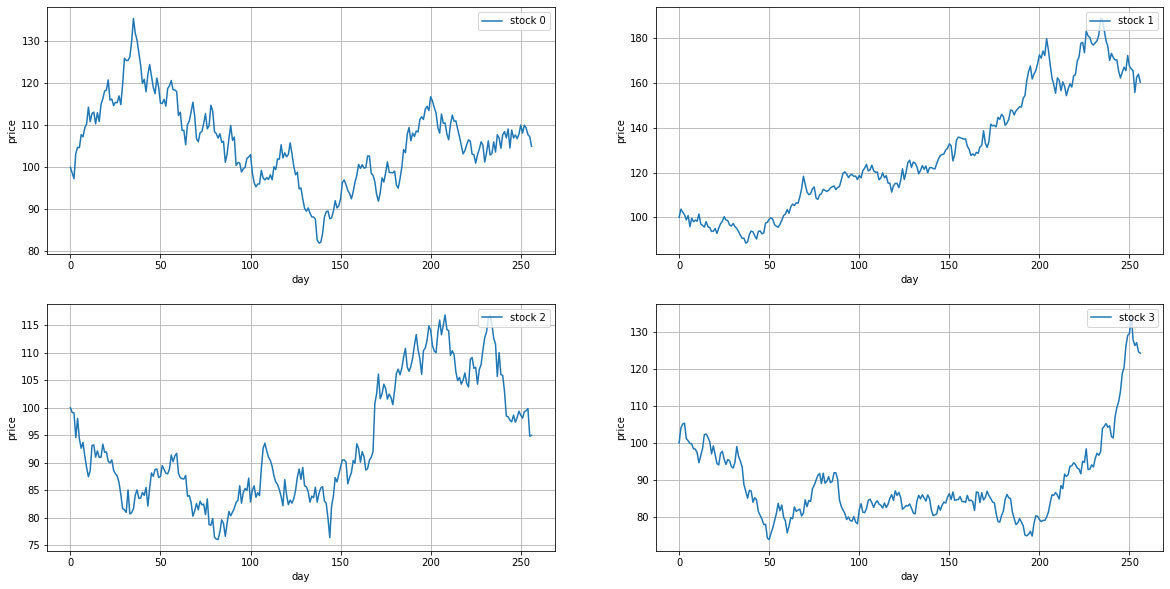

In [18]:
fig, ax = plt.subplots(figsize=(20,10), nrows=2, ncols=2)
for i in range(0, num_stocks):
    p = dict_pricing_data[i]['base_price']
    g = ax[int(i/2), i%2]
    g.plot(np.arange(0, days_to_expiry+1), p, label=f'stock {i}')    
    g.grid()
    g.legend(loc=1)
    g.set_xlabel('day')
    g.set_ylabel('price')

## Question 2

For this question, I will take the first stock price series. Note that 100 strike call is actually in the money, hence it has delta more than 50. According to Black-Scholes, $d1 = \ln(\frac{S}{K} + (r+\frac{1}{2}\sigma^2)\cdot t)*\frac{1}{\sigma \sqrt{t}}$, hence the ATM strike is $K = S*\exp(r+\frac{1}{2}\sigma^2\cdot t)$, which is larger than spot price.

For given base price, time to expiry, strike, rate and implied volatility, we can calculate the delta and value of the call option. In order to stay delta flat, when we first bought the call, we will sell some stocks. However, as time to expiry and stock price changed, we will need to re-hedge to stay delta flat. Take the example below, initially we sold 56 lots of stocks. One day later, stock price goes up, the call gain more delta, so we sell one more stock. At every end of day, we can look at how much the delta of the call has changed, and the opposite of that will be our hedge trade in stock. 

As we are long premium, gamma is favorable for us. At expiration, if the time premium we lost is less than the pnl we gain from gamma hedge, the total portfolio pnl is positive. Equivalently, if the realised volatility is higher than the implied volatility when we bought the call, the total pnl will be positive. 

In [19]:
pricing_data = dict_pricing_data[0]
final_pnl, breakdown = portfolio_pnl(pricing_data, rounding=True)
breakdown

,base_price,tte,option_price,delta,hedge,hedge_volume,hedge_pnl
0,100.000,1.000,13.892,0.567,-57.000,-57.000,-283.952
1,98.651,0.996,13.107,0.553,-55.000,2.000,12.661
2,97.287,0.992,12.336,0.538,-54.000,1.000,7.695
3,103.273,0.988,15.733,0.601,-60.000,-6.000,-10.251
4,104.741,0.984,16.605,0.616,-62.000,-2.000,-0.481
5,104.659,0.980,16.526,0.615,-62.000,0.000,0.000
6,107.755,0.977,18.466,0.645,-65.000,-3.000,8.321
7,107.239,0.973,18.104,0.640,-64.000,1.000,-2.258
8,109.379,0.969,19.481,0.660,-66.000,-2.000,8.795
9,110.265,0.965,20.048,0.669,-67.000,-1.000,5.283


In [20]:
rvol = annual_realised_volatility(pricing_data['base_price'])
print(f"PnL is {final_pnl:,.2f}, realised vol is {rvol:.4f}, implied vol is {annual_volatility:.4f}")

PnL is 23.53, realised vol is 0.3604, implied vol is 0.3500


How many stocks we use to hedge is based on our delta calculation, which use volatility as input. So if we use the "true" volatility from the data generating process as the input for delta calculation, we are likely not ending with zero PnL. 

Furthermore, I want to show, for certain price movement, it's impossible to have a hedge based on the delta position and get to exactly zero PnL. 
Consider a 100 call with one day to expiry, interest rate zero, current spot is 100. Whichever volatility you input, this call will have delta at least $0.5$. So if you hold stock as hedge, that's at least 50 stocks short. Let's say the implied volatility of the call is 20 based on previous days, which is roughly 1% move expected on one day, that means the option is worth 50 cents (so a straddle is worth 1 euro). Tomorrow if this stock move more than the 1% range, we will be up PnL. If it ticks down 2%, the option will expire worthless, so we lose one day premium, but we make 2 euro on each short. 

To illustrate, we can calculate a numerical delta, which by definition is $\frac{P_1-P_0}{S_1-S_0}$, if we always knows the spot price $S_1$ and time 0, we can hedge with such numerical delta, that will surely give zero PnL in the end. Let's go back to the one day to expiry case. If we hedge with the numerical delta, which will be delta $0.277$. According to BS, delta is $\mathcal{N}(d1), $ $d1 = 0.5\sigma \sqrt{t}$, delta has to be at least $0.5$. 

In [22]:
pricing_data = generate_pricing_data(initial_price, 0, 0.2, 1, 100, r=0,seed=200)
# numeric delta
numeric_delta = (pricing_data.shift(1)['option_price'] - pricing_data['option_price'])/(pricing_data.shift(1)['base_price'] - pricing_data['base_price'])
pricing_data.loc[0:days_to_expiry-1, 'delta'] = numeric_delta.dropna().reset_index(drop=True)

pnl, hedge = portfolio_pnl(pricing_data, rounding=False)
print(f"The daily hedge portfolio final pnl : {pnl:,.4f}.")

The daily hedge portfolio final pnl : 0.0000.


In [23]:
pricing_data

,base_price,tte,option_price,delta,hedge,hedge_volume,hedge_pnl
0,100.000,0.004,0.499,0.277,-27.745,-27.745,49.867
1,98.203,0.000,0.000,NaN,NaN,NaN,NaN


As a side note for using zero interest rate, actually even implied and realised vol are the same, we can still lose money because of interest rate (call gives long rho exposure, and theta can be split to volatility part and interest rate part). Think about when we buy two calls, one with implied rate 5%, one is zero rate, the first call will be more expensive. In the end, if base price ended below strike, both calls expire worthless, and some loss will be coming from interest rate for the first call. 

## Question 3

From put call parity we have $C_1 - P_1 = S - K_1\cdot\exp(-rt)$. 
If we can observe prices of put and call in strike $K_1$ and $K_2$, then we can calcualte the iimplied interest rate from the synsthetic swaps. $C_1-P_1 - C_2 + P_2 = (K_2 - K_1)\cdot\exp(-rt)$.

From price of put and call of strike $K_1$, we can calculate the implied spot price as $S=C_1 -P_1 + K_1 \cdot \exp(-rt)$.
Then we can calculate the implied forward as $S\cdot \exp(rt)$.

In [27]:
# we can first generate puts and calls of two strikes
k1 = 100
k2 = 120
c1 = Instrument(Option.Call, tte, k1, initial_price, annual_volatility, r)
c2 = Instrument(Option.Call, tte, k2, initial_price, annual_volatility, r)
p1 = Instrument(Option.Put, tte, k1, initial_price, annual_volatility, r)
p2 = Instrument(Option.Put, tte, k2, initial_price, annual_volatility, r)

for i in [c1, c2, p1, p2]:
    i.price = i.calculate_price()

expected_forward = initial_price*math.exp(r*tte)

print(f"forward : {expected_forward:4f}, implied forward from options {implied_forward(p1, c1, p2, c2):4f}")

forward : 100.000000, implied forward from options 100.000000
